Device: cpu
Extracting bAbI...


/tmp/ipython-input-1195369219.py:52: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(DATA_ROOT)


Train: 1000 Test: 1000
Example answer: bathroom
Vocab: 25 Answers: 6

Training baseline (CE only)...
Epoch 01/8 | avg_loss=1.7911 | test_acc=0.232
Epoch 08/8 | avg_loss=1.2204 | test_acc=0.413

Training full (CE + Ortho + MI + AttnSparse + HeadSparse)...
Epoch 01/8 | avg_loss=2.1390 | test_acc=0.201
Epoch 08/8 | avg_loss=1.4982 | test_acc=0.414

Final baseline test acc: 0.413
Final full test acc: 0.414

Sample tokens: ['john', 'travelled', 'to', 'the', 'hallway', '.', '<ssep>', 'mary', 'journeyed', 'to', 'the', 'bathroom', '.', '<ssep>', '<sep>', 'where', 'is', 'john', '?']
True answer: hallway
Baseline pred: hallway
Full pred: hallway


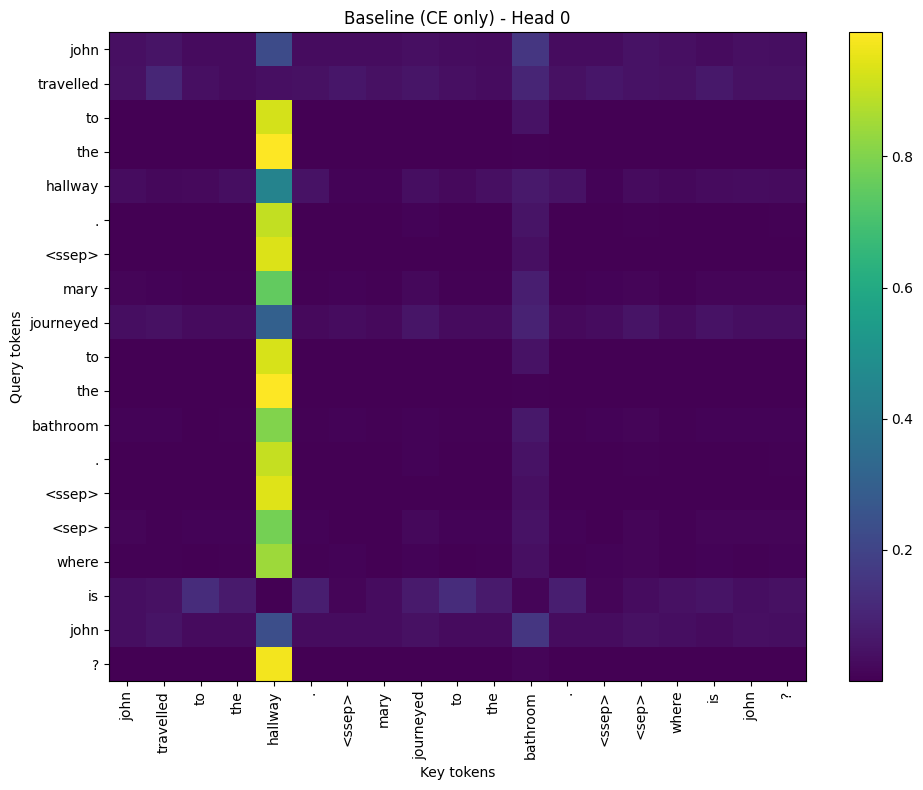

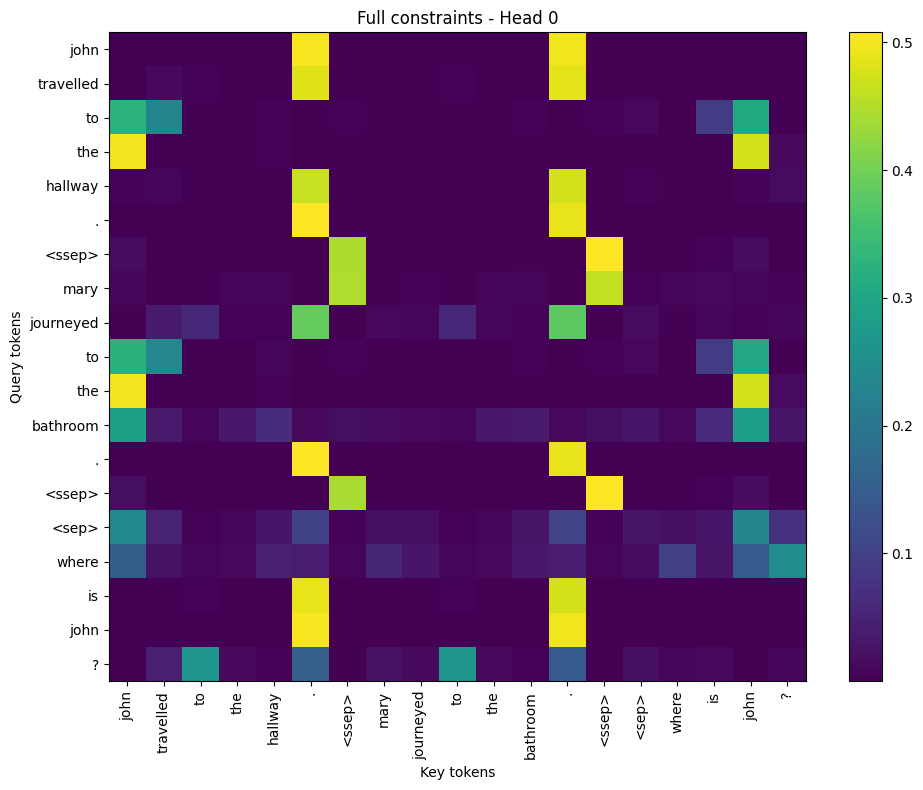

In [1]:
# ============================================================
# Colab-ready: bAbI (Task 1) + Transformer Encoder
# + orthogonality_loss + InfoNCE MI-proxy loss
# + attention_entropy_sparsity_loss + head_usage_sparsity_loss
# + baseline vs full training + before/after attention heatmaps
# ============================================================

# If needed in Colab, uncomment:
# !pip -q install torch --index-url https://download.pytorch.org/whl/cu121

import os, re, tarfile, random, math
from pathlib import Path
from collections import Counter
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Download bAbI
# -------------------------
DATA_ROOT = Path("./data_babi")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

url = "https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz"
tgz_path = DATA_ROOT / "babi_tasks_1-20_v1-2.tar.gz"
extract_dir = DATA_ROOT

if not tgz_path.exists():
    print("Downloading bAbI...")
    urllib.request.urlretrieve(url, tgz_path)

# if not extract_dir.exists():
print("Extracting bAbI...")
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(DATA_ROOT)

# -------------------------
# bAbI parser
# -------------------------
def tokenize(text: str):
    text = text.lower()
    text = re.sub(r"([?.!,])", r" \1 ", text)
    return [t for t in text.split() if t.strip()]

def load_babi_qa(path: Path, max_story_sentences=50):
    samples = []
    story = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            idx_str, rest = line.split(" ", 1)
            idx = int(idx_str)
            if idx == 1:
                story = []
            if "\t" in rest:
                q, a, supporting = rest.split("\t")
                story_tokens = []
                for sent in story[-max_story_sentences:]:
                    story_tokens += tokenize(sent) + ["<ssep>"]
                q_tokens = tokenize(q)
                a_token = a.lower().strip()
                samples.append((story_tokens, q_tokens, a_token))
            else:
                story.append(rest)
    return samples

# Task selection (fast)
TASK_ID = 1
LANG = "en"
train_file = extract_dir / f"tasks_1-20_v1-2/{LANG}/qa{TASK_ID}_single-supporting-fact_train.txt"
test_file  = extract_dir / f"tasks_1-20_v1-2/{LANG}/qa{TASK_ID}_single-supporting-fact_test.txt"

train_samples = load_babi_qa(train_file)
test_samples  = load_babi_qa(test_file)

print("Train:", len(train_samples), "Test:", len(test_samples))
print("Example answer:", train_samples[0][2])

# -------------------------
# Vocab
# -------------------------
SPECIALS = ["<pad>", "<unk>", "<sep>", "<ssep>"]
PAD, UNK, SEP, SSEP = SPECIALS

def build_vocab(samples, min_freq=1):
    counter = Counter()
    answers = Counter()
    for story_tokens, q_tokens, a in samples:
        counter.update(story_tokens)
        counter.update(q_tokens)
        answers[a] += 1

    itos = list(SPECIALS)
    for tok, c in counter.items():
        if c >= min_freq and tok not in itos:
            itos.append(tok)
    stoi = {t: i for i, t in enumerate(itos)}

    ans_itos = sorted(list(answers.keys()))
    ans_stoi = {a: i for i, a in enumerate(ans_itos)}
    return stoi, itos, ans_stoi, ans_itos

stoi, itos, ans_stoi, ans_itos = build_vocab(train_samples + test_samples)
vocab_size = len(itos)
num_answers = len(ans_itos)
print("Vocab:", vocab_size, "Answers:", num_answers)

def encode_tokens(tokens):
    return [stoi.get(t, stoi[UNK]) for t in tokens]

MAX_LEN = 180
def make_input(story_tokens, q_tokens):
    tokens = story_tokens + [SEP] + q_tokens
    ids = encode_tokens(tokens)
    if len(ids) > MAX_LEN:
        ids = ids[-MAX_LEN:]
    return ids

class BabiQADataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        story_tokens, q_tokens, ans = self.samples[idx]
        x = make_input(story_tokens, q_tokens)
        y = ans_stoi[ans]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate(batch):
    xs, ys = zip(*batch)
    maxlen = max(x.size(0) for x in xs)
    x_pad = torch.full((len(xs), maxlen), fill_value=stoi[PAD], dtype=torch.long)
    pad_mask = torch.zeros((len(xs), maxlen), dtype=torch.bool)  # True where PAD
    for i, x in enumerate(xs):
        x_pad[i, :x.size(0)] = x
        pad_mask[i, x.size(0):] = True
    y = torch.stack(ys)
    return x_pad, pad_mask, y

train_loader = DataLoader(BabiQADataset(train_samples), batch_size=64, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(BabiQADataset(test_samples),  batch_size=64, shuffle=False, collate_fn=collate)

# -------------------------
# Model
# -------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1,max_len,D)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttentionExpose(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.o = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        # x: (T,B,D)
        T, B, D = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)

        def to_heads(t):
            t = t.permute(1, 0, 2).contiguous()  # (B,T,D)
            t = t.view(B, T, self.n_heads, self.d_head).transpose(1, 2)  # (B,H,T,Dh)
            return t

        qh, kh, vh = to_heads(q), to_heads(k), to_heads(v)
        scores = torch.matmul(qh, kh.transpose(-2, -1)) / math.sqrt(self.d_head)  # (B,H,T,T)

        if key_padding_mask is not None:
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,T) mask keys
            scores = scores.masked_fill(mask, float("-inf"))

        attn = F.softmax(scores, dim=-1)  # (B,H,T,T)
        attn = self.drop(attn)
        head_out = torch.matmul(attn, vh)  # (B,H,T,Dh)

        merged = head_out.transpose(1, 2).contiguous().view(B, T, D)  # (B,T,D)
        out = self.o(merged).permute(1, 0, 2).contiguous()  # (T,B,D)
        return out, attn, head_out

class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttentionExpose(d_model, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x, key_padding_mask=None):
        h = self.ln1(x)
        attn_out, attn_w, head_out = self.attn(h, key_padding_mask=key_padding_mask)
        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return x, attn_w, head_out

class BabiTransformerQA(nn.Module):
    def __init__(self, vocab_size, num_answers, d_model=128, n_heads=8, n_layers=2, d_ff=256, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len=512)
        self.drop = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderBlock(d_model, n_heads, d_ff, dropout=dropout) for _ in range(n_layers)])
        self.ln_final = nn.LayerNorm(d_model)
        self.cls = nn.Linear(d_model, num_answers)

    def forward(self, x, key_padding_mask):
        # x: (B,T), mask: (B,T) True where PAD
        B, T = x.shape
        h = self.embed(x) * math.sqrt(self.d_model)  # (B,T,D)
        h = self.pos(h)
        h = self.drop(h)
        h = h.transpose(0, 1).contiguous()  # (T,B,D)

        attn_last, head_out_last = None, None
        for layer in self.layers:
            h, attn_w, head_out = layer(h, key_padding_mask=key_padding_mask)
            attn_last, head_out_last = attn_w, head_out  # last layer

        h = self.ln_final(h)               # (T,B,D)
        h_bt = h.transpose(0, 1)           # (B,T,D)

        not_pad = (~key_padding_mask).float().unsqueeze(-1)  # (B,T,1)
        pooled = (h_bt * not_pad).sum(dim=1) / not_pad.sum(dim=1).clamp(min=1.0)  # (B,D)
        logits = self.cls(pooled)

        # Build per-head pooled representations from last-layer head_out (B,H,T,Dh)
        mask_h = (~key_padding_mask).float().unsqueeze(1).unsqueeze(-1)  # (B,1,T,1)
        head_pooled = (head_out_last * mask_h).sum(dim=2) / mask_h.sum(dim=2).clamp(min=1.0)  # (B,H,Dh)
        head_repr = F.pad(head_pooled, (0, self.d_model - head_pooled.size(-1)))  # (B,H,D)
        return logits, head_repr, attn_last, head_out_last

# -------------------------
# Constraints / regularizers
# -------------------------
def orthogonality_loss(head_repr):
    # head_repr: (B,H,D)
    B, H, D = head_repr.shape
    z = F.normalize(head_repr, dim=-1)
    G = torch.matmul(z, z.transpose(1, 2))  # (B,H,H)
    I = torch.eye(H, device=head_repr.device).unsqueeze(0)
    return ((G - I) ** 2).mean()

def info_nce_mi_proxy_loss(head_repr, temperature=0.2):
    # Minimize InfoNCE across head pairs -> reduce dependence (proxy for MI minimization)
    B, H, D = head_repr.shape
    z = F.normalize(head_repr, dim=-1)
    total, count = 0.0, 0
    labels = torch.arange(B, device=head_repr.device)
    for i in range(H):
        zi = z[:, i, :]  # (B,D)
        for j in range(i + 1, H):
            zj = z[:, j, :]
            logits = torch.matmul(zi, zj.t()) / temperature  # (B,B)
            total = total + F.cross_entropy(logits, labels)
            count += 1
    return total / max(count, 1)

def attention_entropy_sparsity_loss(attn, key_padding_mask, eps=1e-9):
    # attn: (B,H,T,T), mask: (B,T) True where PAD
    key_is_pad = key_padding_mask.unsqueeze(1).unsqueeze(2)   # (B,1,1,T)
    attn_masked = attn.masked_fill(key_is_pad, 0.0)
    denom = attn_masked.sum(dim=-1, keepdim=True).clamp(min=eps)
    p = attn_masked / denom                                   # (B,H,T,T)

    entropy = -(p * (p + eps).log()).sum(dim=-1)              # (B,H,T)

    query_valid = (~key_padding_mask).float().unsqueeze(1)    # (B,1,T)
    entropy = entropy * query_valid

    denom_q = query_valid.sum(dim=-1).clamp(min=1.0)          # (B,1)
    entropy_bh = entropy.sum(dim=-1) / denom_q                # (B,H)
    return entropy_bh.mean()

def head_usage_sparsity_loss(head_out, key_padding_mask, eps=1e-9):
    # head_out: (B,H,T,Dh)
    valid = (~key_padding_mask).float().unsqueeze(1).unsqueeze(-1)  # (B,1,T,1)
    mag = (head_out.pow(2).sum(dim=-1) + eps).sqrt()                 # (B,H,T)
    mag = mag * valid.squeeze(-1)                                    # mask PAD tokens
    denom = valid.squeeze(-1).sum(dim=-1).clamp(min=1.0)             # (B,1)

    act_bh = mag.sum(dim=-1) / denom                                 # (B,H)
    act_h = act_bh.mean(dim=0).clamp(min=eps)                        # (H,)
    p = act_h / act_h.sum()
    entropy = -(p * (p + eps).log()).sum()
    return entropy  # minimizing -> sparse head usage

# -------------------------
# Train / eval
# -------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, pad_mask, y in loader:
        x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
        logits, _, _, _ = model(x, pad_mask)
        pred = logits.argmax(dim=-1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(total, 1)

def train_model(model, train_loader, test_loader, optimizer, epochs,
                use_ortho=False, use_mi=False, use_attn_sparse=False, use_head_sparse=False,
                lambda_ortho=0.1, lambda_mi=0.05, lambda_attn=0.02, lambda_head=0.02):
    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for x, pad_mask, y in train_loader:
            x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            logits, head_repr, attn_last, head_out_last = model(x, pad_mask)
            ce = F.cross_entropy(logits, y)
            loss = ce

            if use_ortho:
                loss = loss + lambda_ortho * orthogonality_loss(head_repr)
            if use_mi:
                loss = loss + lambda_mi * info_nce_mi_proxy_loss(head_repr, temperature=0.2)
            if use_attn_sparse:
                loss = loss + lambda_attn * attention_entropy_sparsity_loss(attn_last, pad_mask)
            if use_head_sparse:
                loss = loss + lambda_head * head_usage_sparsity_loss(head_out_last, pad_mask)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += float(loss.detach().cpu())

        if ep == 1 or ep == epochs:
            acc = evaluate(model, test_loader)
            print(f"Epoch {ep:02d}/{epochs} | avg_loss={total_loss/len(train_loader):.4f} | test_acc={acc:.3f}")

# -------------------------
# Helper: decode tokens + pick a sample
# -------------------------
def decode_ids(ids, itos, pad_id):
    toks = []
    for i in ids:
        if int(i) == pad_id:
            break
        toks.append(itos[int(i)])
    return toks

def get_one_example(loader, itos, pad_id, device):
    x, pad_mask, y = next(iter(loader))
    x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
    x0 = x[0].detach().cpu()
    y0 = int(y[0].detach().cpu())
    toks = decode_ids(x0, itos, pad_id)
    T = len(toks)
    return x[0:1], pad_mask[0:1], y0, toks, T

# -------------------------
# Heatmap plotter
# -------------------------
def plot_attention_heatmap(attn_tt, tokens, title="", max_tokens=60):
    T = min(len(tokens), max_tokens)
    A = attn_tt[:T, :T]
    plt.figure(figsize=(10, 8))
    plt.imshow(A, aspect="auto")
    plt.title(title)
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    step = 1 if T <= 30 else 2 if T <= 50 else 3
    xt = np.arange(0, T, step)
    yt = np.arange(0, T, step)
    plt.xticks(xt, [tokens[i] for i in xt], rotation=90)
    plt.yticks(yt, [tokens[i] for i in yt])
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# -------------------------
# Build two models + quick train (baseline vs full)
# -------------------------
baseline = BabiTransformerQA(vocab_size=vocab_size, num_answers=num_answers,
                            d_model=192, n_heads=16, n_layers=3, d_ff=256, dropout=0.1).to(device)
full = BabiTransformerQA(vocab_size=vocab_size, num_answers=num_answers,
                         d_model=192, n_heads=16, n_layers=3, d_ff=256, dropout=0.1).to(device)

opt_base = torch.optim.AdamW(baseline.parameters(), lr=3e-4, weight_decay=1e-2)
opt_full = torch.optim.AdamW(full.parameters(),     lr=3e-4, weight_decay=1e-2)

EPOCHS_QUICK = 8
print("\nTraining baseline (CE only)...")
train_model(baseline, train_loader, test_loader, opt_base, epochs=EPOCHS_QUICK)

print("\nTraining full (CE + Ortho + MI + AttnSparse + HeadSparse)...")
train_model(
    full, train_loader, test_loader, opt_full, epochs=EPOCHS_QUICK,
    use_ortho=True, use_mi=True, use_attn_sparse=True, use_head_sparse=True,
    lambda_ortho=0.1, lambda_mi=0.05, lambda_attn=0.02, lambda_head=0.02
)

print("\nFinal baseline test acc:", evaluate(baseline, test_loader))
print("Final full test acc:", evaluate(full, test_loader))

# -------------------------
# Plot “before vs after” attention heatmaps
# -------------------------
x1, pad1, y_true, tokens, T = get_one_example(test_loader, itos, stoi[PAD], device)
print("\nSample tokens:", tokens[:min(80, len(tokens))])
print("True answer:", ans_itos[y_true])

HEAD_ID = 0
MAX_TOKENS_TO_SHOW = 60

@torch.no_grad()
def get_last_attention_and_pred(model, x, pad_mask, head_id):
    model.eval()
    logits, head_repr, attn_last, head_out_last = model(x, pad_mask)
    pred = int(logits.argmax(dim=-1).detach().cpu())
    attn = attn_last[0, head_id].detach().cpu().numpy()  # (T,T)
    return attn, pred

attn_base, pred_base = get_last_attention_and_pred(baseline, x1, pad1, HEAD_ID)
attn_full, pred_full = get_last_attention_and_pred(full, x1, pad1, HEAD_ID)

print("Baseline pred:", ans_itos[pred_base])
print("Full pred:", ans_itos[pred_full])

plot_attention_heatmap(attn_base, tokens, title=f"Baseline (CE only) - Head {HEAD_ID}", max_tokens=MAX_TOKENS_TO_SHOW)
plot_attention_heatmap(attn_full, tokens, title=f"Full constraints - Head {HEAD_ID}", max_tokens=MAX_TOKENS_TO_SHOW)

# d_model=192, n_heads=16, n_layers=3, d_ff=256

Device: cpu
Extracting bAbI...


/tmp/ipython-input-558437935.py:52: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(DATA_ROOT)


Train: 1000 Test: 1000
Example answer: bathroom
Vocab: 25 Answers: 6

Training baseline (CE only)...
Epoch 01/8 | avg_loss=1.7904 | test_acc=0.197
Epoch 08/8 | avg_loss=1.4093 | test_acc=0.381

Training full (CE + Ortho + MI + AttnSparse + HeadSparse)...
Epoch 01/8 | avg_loss=2.1250 | test_acc=0.188
Epoch 08/8 | avg_loss=1.6570 | test_acc=0.380

Final baseline test acc: 0.381
Final full test acc: 0.38

Sample tokens: ['john', 'travelled', 'to', 'the', 'hallway', '.', '<ssep>', 'mary', 'journeyed', 'to', 'the', 'bathroom', '.', '<ssep>', '<sep>', 'where', 'is', 'john', '?']
True answer: hallway
Baseline pred: hallway
Full pred: hallway


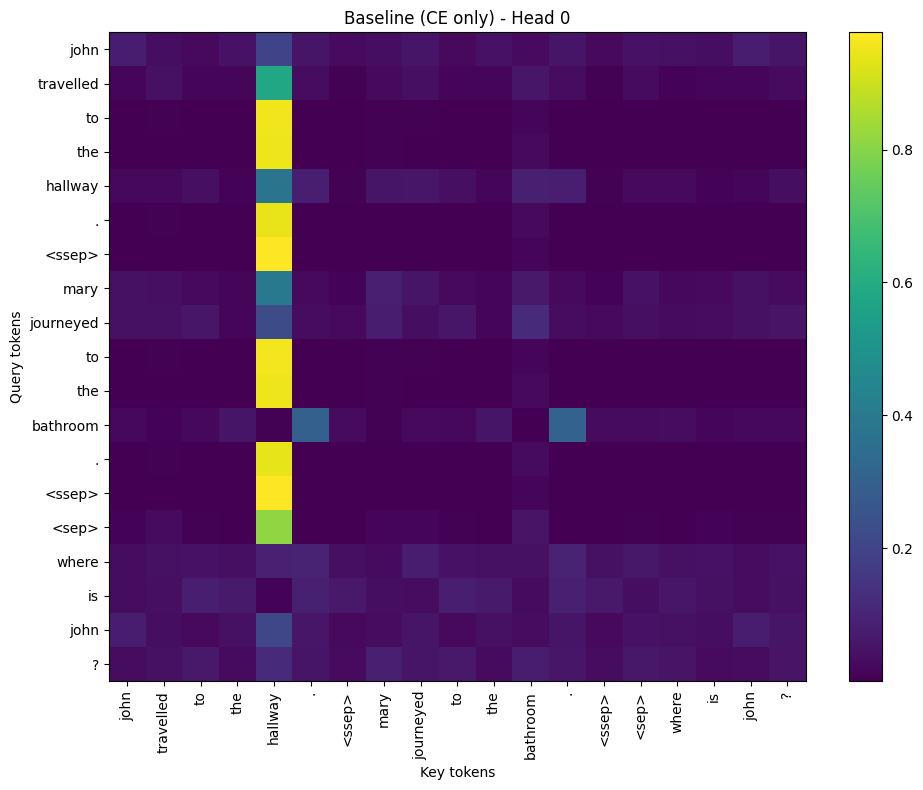

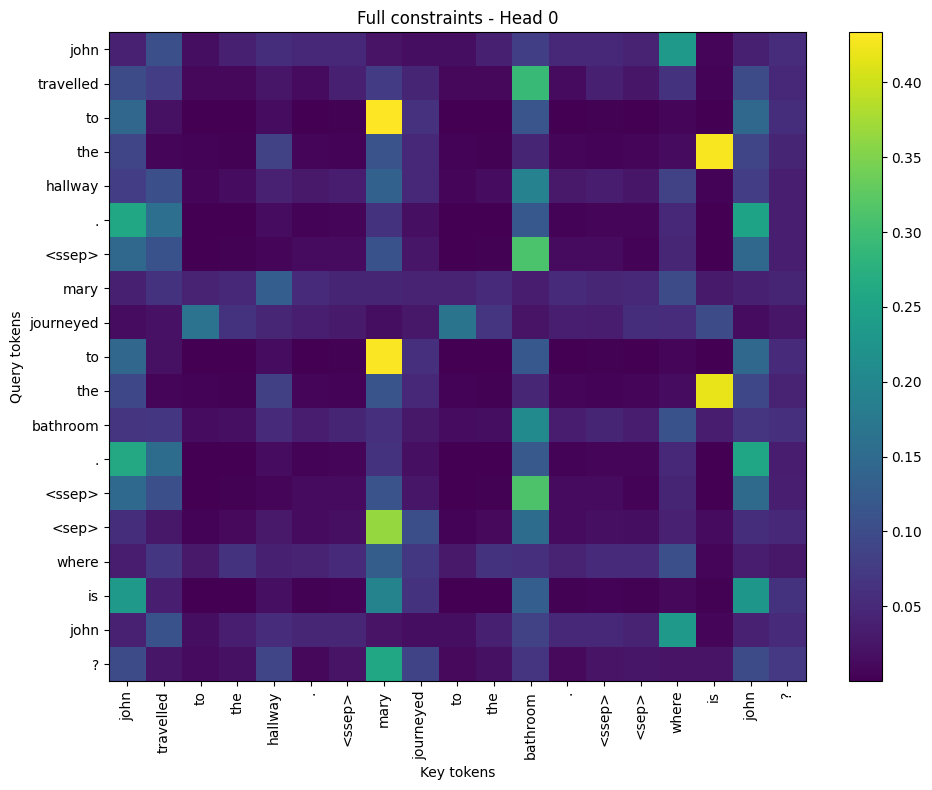

In [2]:
# ============================================================
# Colab-ready: bAbI (Task 1) + Transformer Encoder
# + orthogonality_loss + InfoNCE MI-proxy loss
# + attention_entropy_sparsity_loss + head_usage_sparsity_loss
# + baseline vs full training + before/after attention heatmaps
# ============================================================

# If needed in Colab, uncomment:
# !pip -q install torch --index-url https://download.pytorch.org/whl/cu121

import os, re, tarfile, random, math
from pathlib import Path
from collections import Counter
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Download bAbI
# -------------------------
DATA_ROOT = Path("./data_babi")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

url = "https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz"
tgz_path = DATA_ROOT / "babi_tasks_1-20_v1-2.tar.gz"
extract_dir = DATA_ROOT

if not tgz_path.exists():
    print("Downloading bAbI...")
    urllib.request.urlretrieve(url, tgz_path)

# if not extract_dir.exists():
print("Extracting bAbI...")
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(DATA_ROOT)

# -------------------------
# bAbI parser
# -------------------------
def tokenize(text: str):
    text = text.lower()
    text = re.sub(r"([?.!,])", r" \1 ", text)
    return [t for t in text.split() if t.strip()]

def load_babi_qa(path: Path, max_story_sentences=50):
    samples = []
    story = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            idx_str, rest = line.split(" ", 1)
            idx = int(idx_str)
            if idx == 1:
                story = []
            if "\t" in rest:
                q, a, supporting = rest.split("\t")
                story_tokens = []
                for sent in story[-max_story_sentences:]:
                    story_tokens += tokenize(sent) + ["<ssep>"]
                q_tokens = tokenize(q)
                a_token = a.lower().strip()
                samples.append((story_tokens, q_tokens, a_token))
            else:
                story.append(rest)
    return samples

# Task selection (fast)
TASK_ID = 1
LANG = "en"
train_file = extract_dir / f"tasks_1-20_v1-2/{LANG}/qa{TASK_ID}_single-supporting-fact_train.txt"
test_file  = extract_dir / f"tasks_1-20_v1-2/{LANG}/qa{TASK_ID}_single-supporting-fact_test.txt"

train_samples = load_babi_qa(train_file)
test_samples  = load_babi_qa(test_file)

print("Train:", len(train_samples), "Test:", len(test_samples))
print("Example answer:", train_samples[0][2])

# -------------------------
# Vocab
# -------------------------
SPECIALS = ["<pad>", "<unk>", "<sep>", "<ssep>"]
PAD, UNK, SEP, SSEP = SPECIALS

def build_vocab(samples, min_freq=1):
    counter = Counter()
    answers = Counter()
    for story_tokens, q_tokens, a in samples:
        counter.update(story_tokens)
        counter.update(q_tokens)
        answers[a] += 1

    itos = list(SPECIALS)
    for tok, c in counter.items():
        if c >= min_freq and tok not in itos:
            itos.append(tok)
    stoi = {t: i for i, t in enumerate(itos)}

    ans_itos = sorted(list(answers.keys()))
    ans_stoi = {a: i for i, a in enumerate(ans_itos)}
    return stoi, itos, ans_stoi, ans_itos

stoi, itos, ans_stoi, ans_itos = build_vocab(train_samples + test_samples)
vocab_size = len(itos)
num_answers = len(ans_itos)
print("Vocab:", vocab_size, "Answers:", num_answers)

def encode_tokens(tokens):
    return [stoi.get(t, stoi[UNK]) for t in tokens]

MAX_LEN = 180
def make_input(story_tokens, q_tokens):
    tokens = story_tokens + [SEP] + q_tokens
    ids = encode_tokens(tokens)
    if len(ids) > MAX_LEN:
        ids = ids[-MAX_LEN:]
    return ids

class BabiQADataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        story_tokens, q_tokens, ans = self.samples[idx]
        x = make_input(story_tokens, q_tokens)
        y = ans_stoi[ans]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate(batch):
    xs, ys = zip(*batch)
    maxlen = max(x.size(0) for x in xs)
    x_pad = torch.full((len(xs), maxlen), fill_value=stoi[PAD], dtype=torch.long)
    pad_mask = torch.zeros((len(xs), maxlen), dtype=torch.bool)  # True where PAD
    for i, x in enumerate(xs):
        x_pad[i, :x.size(0)] = x
        pad_mask[i, x.size(0):] = True
    y = torch.stack(ys)
    return x_pad, pad_mask, y

train_loader = DataLoader(BabiQADataset(train_samples), batch_size=64, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(BabiQADataset(test_samples),  batch_size=64, shuffle=False, collate_fn=collate)

# -------------------------
# Model
# -------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1,max_len,D)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttentionExpose(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.o = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        # x: (T,B,D)
        T, B, D = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)

        def to_heads(t):
            t = t.permute(1, 0, 2).contiguous()  # (B,T,D)
            t = t.view(B, T, self.n_heads, self.d_head).transpose(1, 2)  # (B,H,T,Dh)
            return t

        qh, kh, vh = to_heads(q), to_heads(k), to_heads(v)
        scores = torch.matmul(qh, kh.transpose(-2, -1)) / math.sqrt(self.d_head)  # (B,H,T,T)

        if key_padding_mask is not None:
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,T) mask keys
            scores = scores.masked_fill(mask, float("-inf"))

        attn = F.softmax(scores, dim=-1)  # (B,H,T,T)
        attn = self.drop(attn)
        head_out = torch.matmul(attn, vh)  # (B,H,T,Dh)

        merged = head_out.transpose(1, 2).contiguous().view(B, T, D)  # (B,T,D)
        out = self.o(merged).permute(1, 0, 2).contiguous()  # (T,B,D)
        return out, attn, head_out

class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttentionExpose(d_model, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x, key_padding_mask=None):
        h = self.ln1(x)
        attn_out, attn_w, head_out = self.attn(h, key_padding_mask=key_padding_mask)
        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return x, attn_w, head_out

class BabiTransformerQA(nn.Module):
    def __init__(self, vocab_size, num_answers, d_model=128, n_heads=8, n_layers=2, d_ff=256, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len=512)
        self.drop = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderBlock(d_model, n_heads, d_ff, dropout=dropout) for _ in range(n_layers)])
        self.ln_final = nn.LayerNorm(d_model)
        self.cls = nn.Linear(d_model, num_answers)

    def forward(self, x, key_padding_mask):
        # x: (B,T), mask: (B,T) True where PAD
        B, T = x.shape
        h = self.embed(x) * math.sqrt(self.d_model)  # (B,T,D)
        h = self.pos(h)
        h = self.drop(h)
        h = h.transpose(0, 1).contiguous()  # (T,B,D)

        attn_last, head_out_last = None, None
        for layer in self.layers:
            h, attn_w, head_out = layer(h, key_padding_mask=key_padding_mask)
            attn_last, head_out_last = attn_w, head_out  # last layer

        h = self.ln_final(h)               # (T,B,D)
        h_bt = h.transpose(0, 1)           # (B,T,D)

        not_pad = (~key_padding_mask).float().unsqueeze(-1)  # (B,T,1)
        pooled = (h_bt * not_pad).sum(dim=1) / not_pad.sum(dim=1).clamp(min=1.0)  # (B,D)
        logits = self.cls(pooled)

        # Build per-head pooled representations from last-layer head_out (B,H,T,Dh)
        mask_h = (~key_padding_mask).float().unsqueeze(1).unsqueeze(-1)  # (B,1,T,1)
        head_pooled = (head_out_last * mask_h).sum(dim=2) / mask_h.sum(dim=2).clamp(min=1.0)  # (B,H,Dh)
        head_repr = F.pad(head_pooled, (0, self.d_model - head_pooled.size(-1)))  # (B,H,D)
        return logits, head_repr, attn_last, head_out_last

# -------------------------
# Constraints / regularizers
# -------------------------
def orthogonality_loss(head_repr):
    # head_repr: (B,H,D)
    B, H, D = head_repr.shape
    z = F.normalize(head_repr, dim=-1)
    G = torch.matmul(z, z.transpose(1, 2))  # (B,H,H)
    I = torch.eye(H, device=head_repr.device).unsqueeze(0)
    return ((G - I) ** 2).mean()

def info_nce_mi_proxy_loss(head_repr, temperature=0.2):
    # Minimize InfoNCE across head pairs -> reduce dependence (proxy for MI minimization)
    B, H, D = head_repr.shape
    z = F.normalize(head_repr, dim=-1)
    total, count = 0.0, 0
    labels = torch.arange(B, device=head_repr.device)
    for i in range(H):
        zi = z[:, i, :]  # (B,D)
        for j in range(i + 1, H):
            zj = z[:, j, :]
            logits = torch.matmul(zi, zj.t()) / temperature  # (B,B)
            total = total + F.cross_entropy(logits, labels)
            count += 1
    return total / max(count, 1)

def attention_entropy_sparsity_loss(attn, key_padding_mask, eps=1e-9):
    # attn: (B,H,T,T), mask: (B,T) True where PAD
    key_is_pad = key_padding_mask.unsqueeze(1).unsqueeze(2)   # (B,1,1,T)
    attn_masked = attn.masked_fill(key_is_pad, 0.0)
    denom = attn_masked.sum(dim=-1, keepdim=True).clamp(min=eps)
    p = attn_masked / denom                                   # (B,H,T,T)

    entropy = -(p * (p + eps).log()).sum(dim=-1)              # (B,H,T)

    query_valid = (~key_padding_mask).float().unsqueeze(1)    # (B,1,T)
    entropy = entropy * query_valid

    denom_q = query_valid.sum(dim=-1).clamp(min=1.0)          # (B,1)
    entropy_bh = entropy.sum(dim=-1) / denom_q                # (B,H)
    return entropy_bh.mean()

def head_usage_sparsity_loss(head_out, key_padding_mask, eps=1e-9):
    # head_out: (B,H,T,Dh)
    valid = (~key_padding_mask).float().unsqueeze(1).unsqueeze(-1)  # (B,1,T,1)
    mag = (head_out.pow(2).sum(dim=-1) + eps).sqrt()                 # (B,H,T)
    mag = mag * valid.squeeze(-1)                                    # mask PAD tokens
    denom = valid.squeeze(-1).sum(dim=-1).clamp(min=1.0)             # (B,1)

    act_bh = mag.sum(dim=-1) / denom                                 # (B,H)
    act_h = act_bh.mean(dim=0).clamp(min=eps)                        # (H,)
    p = act_h / act_h.sum()
    entropy = -(p * (p + eps).log()).sum()
    return entropy  # minimizing -> sparse head usage

# -------------------------
# Train / eval
# -------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, pad_mask, y in loader:
        x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
        logits, _, _, _ = model(x, pad_mask)
        pred = logits.argmax(dim=-1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(total, 1)

def train_model(model, train_loader, test_loader, optimizer, epochs,
                use_ortho=False, use_mi=False, use_attn_sparse=False, use_head_sparse=False,
                lambda_ortho=0.1, lambda_mi=0.05, lambda_attn=0.02, lambda_head=0.02):
    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for x, pad_mask, y in train_loader:
            x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            logits, head_repr, attn_last, head_out_last = model(x, pad_mask)
            ce = F.cross_entropy(logits, y)
            loss = ce

            if use_ortho:
                loss = loss + lambda_ortho * orthogonality_loss(head_repr)
            if use_mi:
                loss = loss + lambda_mi * info_nce_mi_proxy_loss(head_repr, temperature=0.2)
            if use_attn_sparse:
                loss = loss + lambda_attn * attention_entropy_sparsity_loss(attn_last, pad_mask)
            if use_head_sparse:
                loss = loss + lambda_head * head_usage_sparsity_loss(head_out_last, pad_mask)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += float(loss.detach().cpu())

        if ep == 1 or ep == epochs:
            acc = evaluate(model, test_loader)
            print(f"Epoch {ep:02d}/{epochs} | avg_loss={total_loss/len(train_loader):.4f} | test_acc={acc:.3f}")

# -------------------------
# Helper: decode tokens + pick a sample
# -------------------------
def decode_ids(ids, itos, pad_id):
    toks = []
    for i in ids:
        if int(i) == pad_id:
            break
        toks.append(itos[int(i)])
    return toks

def get_one_example(loader, itos, pad_id, device):
    x, pad_mask, y = next(iter(loader))
    x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
    x0 = x[0].detach().cpu()
    y0 = int(y[0].detach().cpu())
    toks = decode_ids(x0, itos, pad_id)
    T = len(toks)
    return x[0:1], pad_mask[0:1], y0, toks, T

# -------------------------
# Heatmap plotter
# -------------------------
def plot_attention_heatmap(attn_tt, tokens, title="", max_tokens=60):
    T = min(len(tokens), max_tokens)
    A = attn_tt[:T, :T]
    plt.figure(figsize=(10, 8))
    plt.imshow(A, aspect="auto")
    plt.title(title)
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    step = 1 if T <= 30 else 2 if T <= 50 else 3
    xt = np.arange(0, T, step)
    yt = np.arange(0, T, step)
    plt.xticks(xt, [tokens[i] for i in xt], rotation=90)
    plt.yticks(yt, [tokens[i] for i in yt])
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# -------------------------
# Build two models + quick train (baseline vs full)
# -------------------------
baseline = BabiTransformerQA(vocab_size=vocab_size, num_answers=num_answers,
                            d_model=128, n_heads=8, n_layers=2, d_ff=512, dropout=0.1).to(device)
full = BabiTransformerQA(vocab_size=vocab_size, num_answers=num_answers,
                         d_model=128, n_heads=8, n_layers=2, d_ff=512, dropout=0.1).to(device)

opt_base = torch.optim.AdamW(baseline.parameters(), lr=3e-4, weight_decay=1e-2)
opt_full = torch.optim.AdamW(full.parameters(),     lr=3e-4, weight_decay=1e-2)

EPOCHS_QUICK = 8
print("\nTraining baseline (CE only)...")
train_model(baseline, train_loader, test_loader, opt_base, epochs=EPOCHS_QUICK)

print("\nTraining full (CE + Ortho + MI + AttnSparse + HeadSparse)...")
train_model(
    full, train_loader, test_loader, opt_full, epochs=EPOCHS_QUICK,
    use_ortho=True, use_mi=True, use_attn_sparse=True, use_head_sparse=True,
    lambda_ortho=0.1, lambda_mi=0.05, lambda_attn=0.02, lambda_head=0.02
)

print("\nFinal baseline test acc:", evaluate(baseline, test_loader))
print("Final full test acc:", evaluate(full, test_loader))

# -------------------------
# Plot “before vs after” attention heatmaps
# -------------------------
x1, pad1, y_true, tokens, T = get_one_example(test_loader, itos, stoi[PAD], device)
print("\nSample tokens:", tokens[:min(80, len(tokens))])
print("True answer:", ans_itos[y_true])

HEAD_ID = 0
MAX_TOKENS_TO_SHOW = 60

@torch.no_grad()
def get_last_attention_and_pred(model, x, pad_mask, head_id):
    model.eval()
    logits, head_repr, attn_last, head_out_last = model(x, pad_mask)
    pred = int(logits.argmax(dim=-1).detach().cpu())
    attn = attn_last[0, head_id].detach().cpu().numpy()  # (T,T)
    return attn, pred

attn_base, pred_base = get_last_attention_and_pred(baseline, x1, pad1, HEAD_ID)
attn_full, pred_full = get_last_attention_and_pred(full, x1, pad1, HEAD_ID)

print("Baseline pred:", ans_itos[pred_base])
print("Full pred:", ans_itos[pred_full])

plot_attention_heatmap(attn_base, tokens, title=f"Baseline (CE only) - Head {HEAD_ID}", max_tokens=MAX_TOKENS_TO_SHOW)
plot_attention_heatmap(attn_full, tokens, title=f"Full constraints - Head {HEAD_ID}", max_tokens=MAX_TOKENS_TO_SHOW)
# d_model=128, n_heads=8, n_layers=2, d_ff=512

Device: cpu
Extracting bAbI...


/tmp/ipython-input-1868946092.py:52: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(DATA_ROOT)


Train: 1000 Test: 1000
Example answer: bathroom
Vocab: 25 Answers: 6

Training baseline (CE only)...
Epoch 01/8 | avg_loss=1.7934 | test_acc=0.245
Epoch 08/8 | avg_loss=1.2408 | test_acc=0.406

Training full (CE + Ortho + MI + AttnSparse + HeadSparse)...
Epoch 01/8 | avg_loss=2.1364 | test_acc=0.218
Epoch 08/8 | avg_loss=1.5183 | test_acc=0.386

Final baseline test acc: 0.406
Final full test acc: 0.386

Sample tokens: ['john', 'travelled', 'to', 'the', 'hallway', '.', '<ssep>', 'mary', 'journeyed', 'to', 'the', 'bathroom', '.', '<ssep>', '<sep>', 'where', 'is', 'john', '?']
True answer: hallway
Baseline pred: hallway
Full pred: hallway


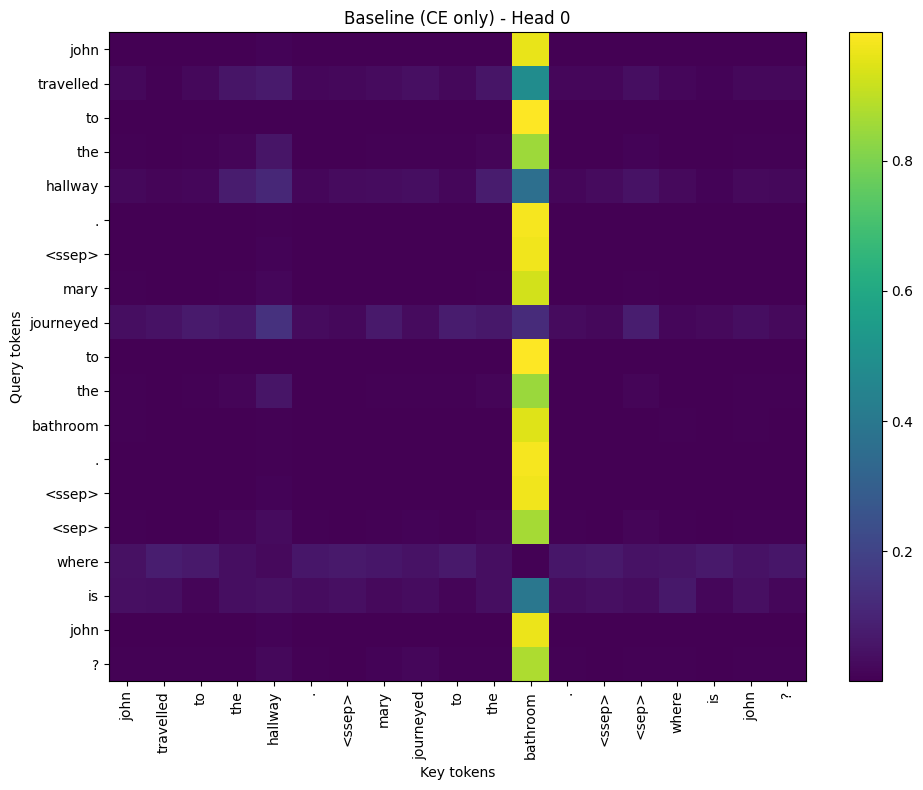

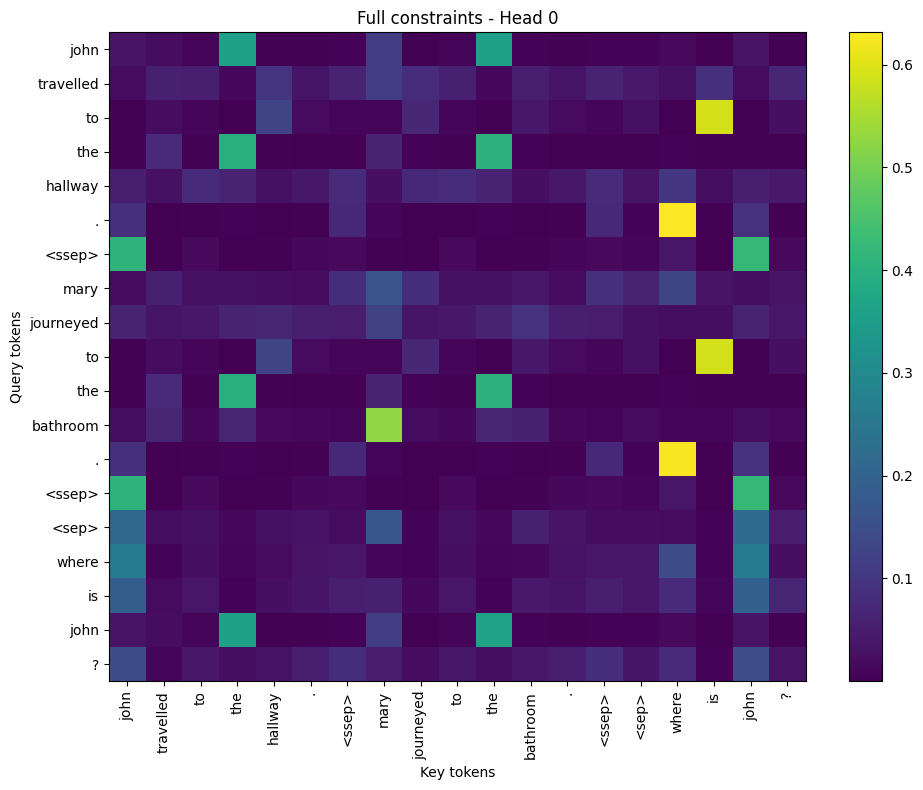

In [3]:
# ============================================================
# Colab-ready: bAbI (Task 1) + Transformer Encoder
# + orthogonality_loss + InfoNCE MI-proxy loss
# + attention_entropy_sparsity_loss + head_usage_sparsity_loss
# + baseline vs full training + before/after attention heatmaps
# ============================================================

# If needed in Colab, uncomment:
# !pip -q install torch --index-url https://download.pytorch.org/whl/cu121

import os, re, tarfile, random, math
from pathlib import Path
from collections import Counter
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Download bAbI
# -------------------------
DATA_ROOT = Path("./data_babi")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

url = "https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz"
tgz_path = DATA_ROOT / "babi_tasks_1-20_v1-2.tar.gz"
extract_dir = DATA_ROOT

if not tgz_path.exists():
    print("Downloading bAbI...")
    urllib.request.urlretrieve(url, tgz_path)

# if not extract_dir.exists():
print("Extracting bAbI...")
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(DATA_ROOT)

# -------------------------
# bAbI parser
# -------------------------
def tokenize(text: str):
    text = text.lower()
    text = re.sub(r"([?.!,])", r" \1 ", text)
    return [t for t in text.split() if t.strip()]

def load_babi_qa(path: Path, max_story_sentences=50):
    samples = []
    story = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            idx_str, rest = line.split(" ", 1)
            idx = int(idx_str)
            if idx == 1:
                story = []
            if "\t" in rest:
                q, a, supporting = rest.split("\t")
                story_tokens = []
                for sent in story[-max_story_sentences:]:
                    story_tokens += tokenize(sent) + ["<ssep>"]
                q_tokens = tokenize(q)
                a_token = a.lower().strip()
                samples.append((story_tokens, q_tokens, a_token))
            else:
                story.append(rest)
    return samples

# Task selection (fast)
TASK_ID = 1
LANG = "en"
train_file = extract_dir / f"tasks_1-20_v1-2/{LANG}/qa{TASK_ID}_single-supporting-fact_train.txt"
test_file  = extract_dir / f"tasks_1-20_v1-2/{LANG}/qa{TASK_ID}_single-supporting-fact_test.txt"

train_samples = load_babi_qa(train_file)
test_samples  = load_babi_qa(test_file)

print("Train:", len(train_samples), "Test:", len(test_samples))
print("Example answer:", train_samples[0][2])

# -------------------------
# Vocab
# -------------------------
SPECIALS = ["<pad>", "<unk>", "<sep>", "<ssep>"]
PAD, UNK, SEP, SSEP = SPECIALS

def build_vocab(samples, min_freq=1):
    counter = Counter()
    answers = Counter()
    for story_tokens, q_tokens, a in samples:
        counter.update(story_tokens)
        counter.update(q_tokens)
        answers[a] += 1

    itos = list(SPECIALS)
    for tok, c in counter.items():
        if c >= min_freq and tok not in itos:
            itos.append(tok)
    stoi = {t: i for i, t in enumerate(itos)}

    ans_itos = sorted(list(answers.keys()))
    ans_stoi = {a: i for i, a in enumerate(ans_itos)}
    return stoi, itos, ans_stoi, ans_itos

stoi, itos, ans_stoi, ans_itos = build_vocab(train_samples + test_samples)
vocab_size = len(itos)
num_answers = len(ans_itos)
print("Vocab:", vocab_size, "Answers:", num_answers)

def encode_tokens(tokens):
    return [stoi.get(t, stoi[UNK]) for t in tokens]

MAX_LEN = 180
def make_input(story_tokens, q_tokens):
    tokens = story_tokens + [SEP] + q_tokens
    ids = encode_tokens(tokens)
    if len(ids) > MAX_LEN:
        ids = ids[-MAX_LEN:]
    return ids

class BabiQADataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        story_tokens, q_tokens, ans = self.samples[idx]
        x = make_input(story_tokens, q_tokens)
        y = ans_stoi[ans]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate(batch):
    xs, ys = zip(*batch)
    maxlen = max(x.size(0) for x in xs)
    x_pad = torch.full((len(xs), maxlen), fill_value=stoi[PAD], dtype=torch.long)
    pad_mask = torch.zeros((len(xs), maxlen), dtype=torch.bool)  # True where PAD
    for i, x in enumerate(xs):
        x_pad[i, :x.size(0)] = x
        pad_mask[i, x.size(0):] = True
    y = torch.stack(ys)
    return x_pad, pad_mask, y

train_loader = DataLoader(BabiQADataset(train_samples), batch_size=64, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(BabiQADataset(test_samples),  batch_size=64, shuffle=False, collate_fn=collate)

# -------------------------
# Model
# -------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1,max_len,D)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttentionExpose(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.o = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        # x: (T,B,D)
        T, B, D = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)

        def to_heads(t):
            t = t.permute(1, 0, 2).contiguous()  # (B,T,D)
            t = t.view(B, T, self.n_heads, self.d_head).transpose(1, 2)  # (B,H,T,Dh)
            return t

        qh, kh, vh = to_heads(q), to_heads(k), to_heads(v)
        scores = torch.matmul(qh, kh.transpose(-2, -1)) / math.sqrt(self.d_head)  # (B,H,T,T)

        if key_padding_mask is not None:
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,T) mask keys
            scores = scores.masked_fill(mask, float("-inf"))

        attn = F.softmax(scores, dim=-1)  # (B,H,T,T)
        attn = self.drop(attn)
        head_out = torch.matmul(attn, vh)  # (B,H,T,Dh)

        merged = head_out.transpose(1, 2).contiguous().view(B, T, D)  # (B,T,D)
        out = self.o(merged).permute(1, 0, 2).contiguous()  # (T,B,D)
        return out, attn, head_out

class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttentionExpose(d_model, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x, key_padding_mask=None):
        h = self.ln1(x)
        attn_out, attn_w, head_out = self.attn(h, key_padding_mask=key_padding_mask)
        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return x, attn_w, head_out

class BabiTransformerQA(nn.Module):
    def __init__(self, vocab_size, num_answers, d_model=128, n_heads=8, n_layers=2, d_ff=256, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len=512)
        self.drop = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderBlock(d_model, n_heads, d_ff, dropout=dropout) for _ in range(n_layers)])
        self.ln_final = nn.LayerNorm(d_model)
        self.cls = nn.Linear(d_model, num_answers)

    def forward(self, x, key_padding_mask):
        # x: (B,T), mask: (B,T) True where PAD
        B, T = x.shape
        h = self.embed(x) * math.sqrt(self.d_model)  # (B,T,D)
        h = self.pos(h)
        h = self.drop(h)
        h = h.transpose(0, 1).contiguous()  # (T,B,D)

        attn_last, head_out_last = None, None
        for layer in self.layers:
            h, attn_w, head_out = layer(h, key_padding_mask=key_padding_mask)
            attn_last, head_out_last = attn_w, head_out  # last layer

        h = self.ln_final(h)               # (T,B,D)
        h_bt = h.transpose(0, 1)           # (B,T,D)

        not_pad = (~key_padding_mask).float().unsqueeze(-1)  # (B,T,1)
        pooled = (h_bt * not_pad).sum(dim=1) / not_pad.sum(dim=1).clamp(min=1.0)  # (B,D)
        logits = self.cls(pooled)

        # Build per-head pooled representations from last-layer head_out (B,H,T,Dh)
        mask_h = (~key_padding_mask).float().unsqueeze(1).unsqueeze(-1)  # (B,1,T,1)
        head_pooled = (head_out_last * mask_h).sum(dim=2) / mask_h.sum(dim=2).clamp(min=1.0)  # (B,H,Dh)
        head_repr = F.pad(head_pooled, (0, self.d_model - head_pooled.size(-1)))  # (B,H,D)
        return logits, head_repr, attn_last, head_out_last

# -------------------------
# Constraints / regularizers
# -------------------------
def orthogonality_loss(head_repr):
    # head_repr: (B,H,D)
    B, H, D = head_repr.shape
    z = F.normalize(head_repr, dim=-1)
    G = torch.matmul(z, z.transpose(1, 2))  # (B,H,H)
    I = torch.eye(H, device=head_repr.device).unsqueeze(0)
    return ((G - I) ** 2).mean()

def info_nce_mi_proxy_loss(head_repr, temperature=0.2):
    # Minimize InfoNCE across head pairs -> reduce dependence (proxy for MI minimization)
    B, H, D = head_repr.shape
    z = F.normalize(head_repr, dim=-1)
    total, count = 0.0, 0
    labels = torch.arange(B, device=head_repr.device)
    for i in range(H):
        zi = z[:, i, :]  # (B,D)
        for j in range(i + 1, H):
            zj = z[:, j, :]
            logits = torch.matmul(zi, zj.t()) / temperature  # (B,B)
            total = total + F.cross_entropy(logits, labels)
            count += 1
    return total / max(count, 1)

def attention_entropy_sparsity_loss(attn, key_padding_mask, eps=1e-9):
    # attn: (B,H,T,T), mask: (B,T) True where PAD
    key_is_pad = key_padding_mask.unsqueeze(1).unsqueeze(2)   # (B,1,1,T)
    attn_masked = attn.masked_fill(key_is_pad, 0.0)
    denom = attn_masked.sum(dim=-1, keepdim=True).clamp(min=eps)
    p = attn_masked / denom                                   # (B,H,T,T)

    entropy = -(p * (p + eps).log()).sum(dim=-1)              # (B,H,T)

    query_valid = (~key_padding_mask).float().unsqueeze(1)    # (B,1,T)
    entropy = entropy * query_valid

    denom_q = query_valid.sum(dim=-1).clamp(min=1.0)          # (B,1)
    entropy_bh = entropy.sum(dim=-1) / denom_q                # (B,H)
    return entropy_bh.mean()

def head_usage_sparsity_loss(head_out, key_padding_mask, eps=1e-9):
    # head_out: (B,H,T,Dh)
    valid = (~key_padding_mask).float().unsqueeze(1).unsqueeze(-1)  # (B,1,T,1)
    mag = (head_out.pow(2).sum(dim=-1) + eps).sqrt()                 # (B,H,T)
    mag = mag * valid.squeeze(-1)                                    # mask PAD tokens
    denom = valid.squeeze(-1).sum(dim=-1).clamp(min=1.0)             # (B,1)

    act_bh = mag.sum(dim=-1) / denom                                 # (B,H)
    act_h = act_bh.mean(dim=0).clamp(min=eps)                        # (H,)
    p = act_h / act_h.sum()
    entropy = -(p * (p + eps).log()).sum()
    return entropy  # minimizing -> sparse head usage

# -------------------------
# Train / eval
# -------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, pad_mask, y in loader:
        x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
        logits, _, _, _ = model(x, pad_mask)
        pred = logits.argmax(dim=-1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(total, 1)

def train_model(model, train_loader, test_loader, optimizer, epochs,
                use_ortho=False, use_mi=False, use_attn_sparse=False, use_head_sparse=False,
                lambda_ortho=0.1, lambda_mi=0.05, lambda_attn=0.02, lambda_head=0.02):
    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for x, pad_mask, y in train_loader:
            x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            logits, head_repr, attn_last, head_out_last = model(x, pad_mask)
            ce = F.cross_entropy(logits, y)
            loss = ce

            if use_ortho:
                loss = loss + lambda_ortho * orthogonality_loss(head_repr)
            if use_mi:
                loss = loss + lambda_mi * info_nce_mi_proxy_loss(head_repr, temperature=0.2)
            if use_attn_sparse:
                loss = loss + lambda_attn * attention_entropy_sparsity_loss(attn_last, pad_mask)
            if use_head_sparse:
                loss = loss + lambda_head * head_usage_sparsity_loss(head_out_last, pad_mask)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += float(loss.detach().cpu())

        if ep == 1 or ep == epochs:
            acc = evaluate(model, test_loader)
            print(f"Epoch {ep:02d}/{epochs} | avg_loss={total_loss/len(train_loader):.4f} | test_acc={acc:.3f}")

# -------------------------
# Helper: decode tokens + pick a sample
# -------------------------
def decode_ids(ids, itos, pad_id):
    toks = []
    for i in ids:
        if int(i) == pad_id:
            break
        toks.append(itos[int(i)])
    return toks

def get_one_example(loader, itos, pad_id, device):
    x, pad_mask, y = next(iter(loader))
    x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
    x0 = x[0].detach().cpu()
    y0 = int(y[0].detach().cpu())
    toks = decode_ids(x0, itos, pad_id)
    T = len(toks)
    return x[0:1], pad_mask[0:1], y0, toks, T

# -------------------------
# Heatmap plotter
# -------------------------
def plot_attention_heatmap(attn_tt, tokens, title="", max_tokens=60):
    T = min(len(tokens), max_tokens)
    A = attn_tt[:T, :T]
    plt.figure(figsize=(10, 8))
    plt.imshow(A, aspect="auto")
    plt.title(title)
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    step = 1 if T <= 30 else 2 if T <= 50 else 3
    xt = np.arange(0, T, step)
    yt = np.arange(0, T, step)
    plt.xticks(xt, [tokens[i] for i in xt], rotation=90)
    plt.yticks(yt, [tokens[i] for i in yt])
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# -------------------------
# Build two models + quick train (baseline vs full)
# -------------------------
baseline = BabiTransformerQA(vocab_size=vocab_size, num_answers=num_answers,
                            d_model=192, n_heads=16, n_layers=3, d_ff=512, dropout=0.1).to(device)
full = BabiTransformerQA(vocab_size=vocab_size, num_answers=num_answers,
                         d_model=192, n_heads=16, n_layers=3, d_ff=512, dropout=0.1).to(device)

opt_base = torch.optim.AdamW(baseline.parameters(), lr=3e-4, weight_decay=1e-2)
opt_full = torch.optim.AdamW(full.parameters(),     lr=3e-4, weight_decay=1e-2)

EPOCHS_QUICK = 8
print("\nTraining baseline (CE only)...")
train_model(baseline, train_loader, test_loader, opt_base, epochs=EPOCHS_QUICK)

print("\nTraining full (CE + Ortho + MI + AttnSparse + HeadSparse)...")
train_model(
    full, train_loader, test_loader, opt_full, epochs=EPOCHS_QUICK,
    use_ortho=True, use_mi=True, use_attn_sparse=True, use_head_sparse=True,
    lambda_ortho=0.1, lambda_mi=0.05, lambda_attn=0.02, lambda_head=0.02
)

print("\nFinal baseline test acc:", evaluate(baseline, test_loader))
print("Final full test acc:", evaluate(full, test_loader))

# -------------------------
# Plot “before vs after” attention heatmaps
# -------------------------
x1, pad1, y_true, tokens, T = get_one_example(test_loader, itos, stoi[PAD], device)
print("\nSample tokens:", tokens[:min(80, len(tokens))])
print("True answer:", ans_itos[y_true])

HEAD_ID = 0
MAX_TOKENS_TO_SHOW = 60

@torch.no_grad()
def get_last_attention_and_pred(model, x, pad_mask, head_id):
    model.eval()
    logits, head_repr, attn_last, head_out_last = model(x, pad_mask)
    pred = int(logits.argmax(dim=-1).detach().cpu())
    attn = attn_last[0, head_id].detach().cpu().numpy()  # (T,T)
    return attn, pred

attn_base, pred_base = get_last_attention_and_pred(baseline, x1, pad1, HEAD_ID)
attn_full, pred_full = get_last_attention_and_pred(full, x1, pad1, HEAD_ID)

print("Baseline pred:", ans_itos[pred_base])
print("Full pred:", ans_itos[pred_full])

plot_attention_heatmap(attn_base, tokens, title=f"Baseline (CE only) - Head {HEAD_ID}", max_tokens=MAX_TOKENS_TO_SHOW)
plot_attention_heatmap(attn_full, tokens, title=f"Full constraints - Head {HEAD_ID}", max_tokens=MAX_TOKENS_TO_SHOW)


Device: cpu
Extracting bAbI...


/tmp/ipython-input-2554460000.py:52: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(DATA_ROOT)


Train: 1000 Test: 1000
Example answer: bathroom
Vocab: 25 Answers: 6

Training baseline (CE only)...
Epoch 01/2 | avg_loss=1.7934 | test_acc=0.245
Epoch 02/2 | avg_loss=1.7649 | test_acc=0.281

Training full (CE + Ortho + MI + AttnSparse + HeadSparse)...
Epoch 01/16 | avg_loss=2.1388 | test_acc=0.222
Epoch 16/16 | avg_loss=1.3733 | test_acc=0.404

Final baseline test acc: 0.281
Final full test acc: 0.404

Sample tokens: ['john', 'travelled', 'to', 'the', 'hallway', '.', '<ssep>', 'mary', 'journeyed', 'to', 'the', 'bathroom', '.', '<ssep>', '<sep>', 'where', 'is', 'john', '?']
True answer: hallway
Baseline pred: hallway
Full pred: hallway


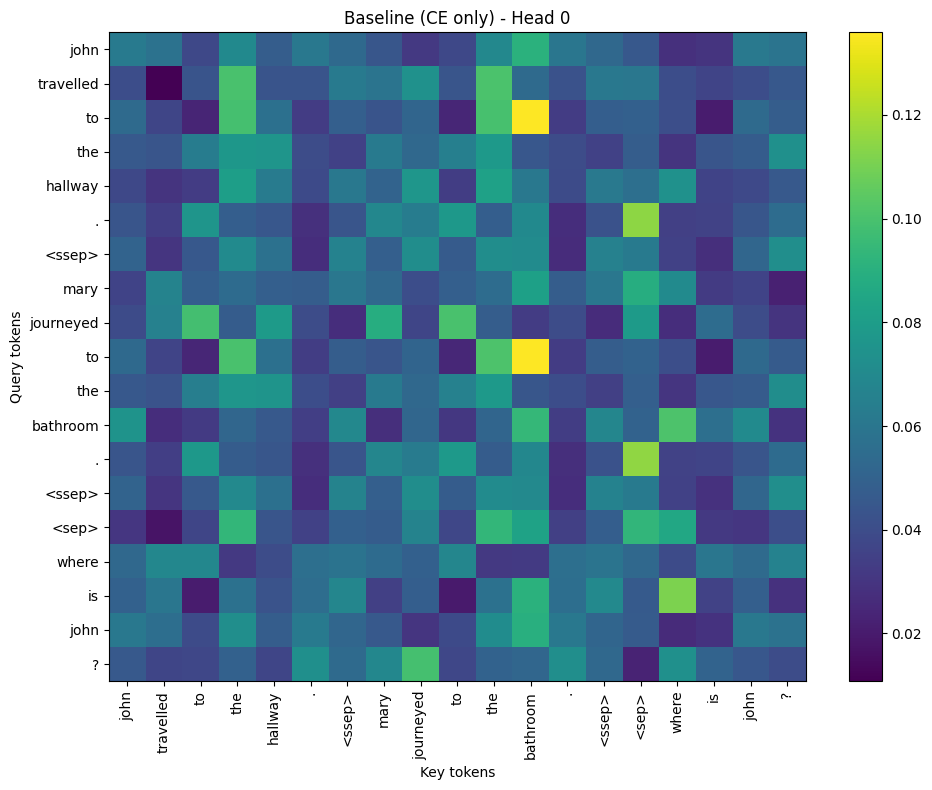

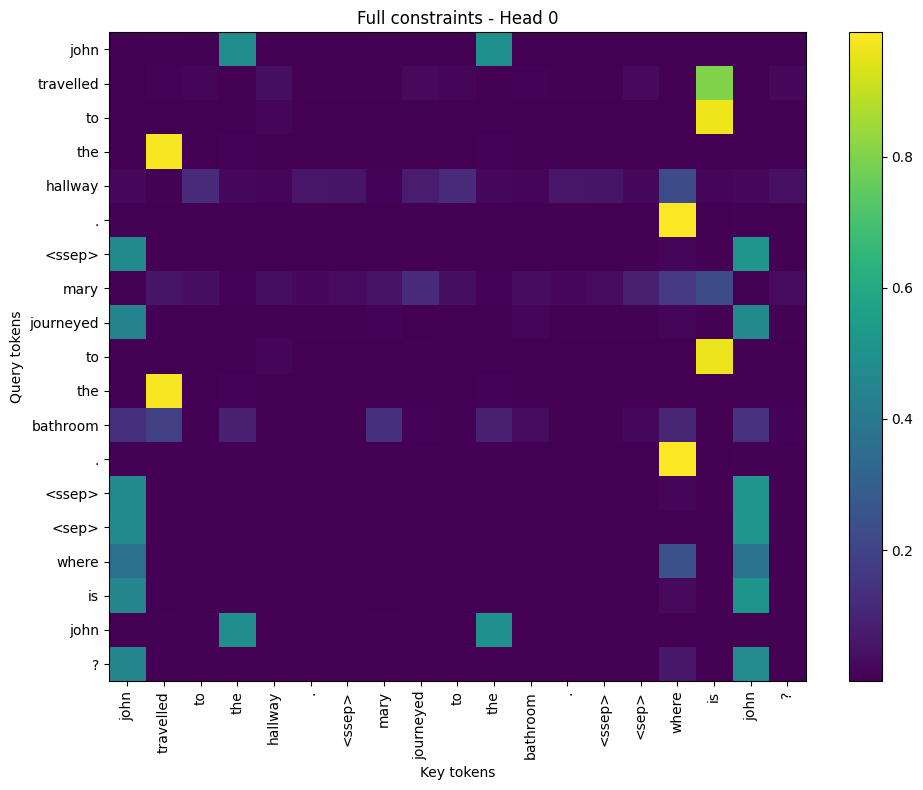

In [5]:
# ============================================================
# Colab-ready: bAbI (Task 1) + Transformer Encoder
# + orthogonality_loss + InfoNCE MI-proxy loss
# + attention_entropy_sparsity_loss + head_usage_sparsity_loss
# + baseline vs full training + before/after attention heatmaps
# ============================================================

# If needed in Colab, uncomment:
# !pip -q install torch --index-url https://download.pytorch.org/whl/cu121

import os, re, tarfile, random, math
from pathlib import Path
from collections import Counter
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Download bAbI
# -------------------------
DATA_ROOT = Path("./data_babi")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

url = "https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz"
tgz_path = DATA_ROOT / "babi_tasks_1-20_v1-2.tar.gz"
extract_dir = DATA_ROOT

if not tgz_path.exists():
    print("Downloading bAbI...")
    urllib.request.urlretrieve(url, tgz_path)

# if not extract_dir.exists():
print("Extracting bAbI...")
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(DATA_ROOT)

# -------------------------
# bAbI parser
# -------------------------
def tokenize(text: str):
    text = text.lower()
    text = re.sub(r"([?.!,])", r" \1 ", text)
    return [t for t in text.split() if t.strip()]

def load_babi_qa(path: Path, max_story_sentences=50):
    samples = []
    story = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            idx_str, rest = line.split(" ", 1)
            idx = int(idx_str)
            if idx == 1:
                story = []
            if "\t" in rest:
                q, a, supporting = rest.split("\t")
                story_tokens = []
                for sent in story[-max_story_sentences:]:
                    story_tokens += tokenize(sent) + ["<ssep>"]
                q_tokens = tokenize(q)
                a_token = a.lower().strip()
                samples.append((story_tokens, q_tokens, a_token))
            else:
                story.append(rest)
    return samples

# Task selection (fast)
TASK_ID = 1
LANG = "en"
train_file = extract_dir / f"tasks_1-20_v1-2/{LANG}/qa{TASK_ID}_single-supporting-fact_train.txt"
test_file  = extract_dir / f"tasks_1-20_v1-2/{LANG}/qa{TASK_ID}_single-supporting-fact_test.txt"

train_samples = load_babi_qa(train_file)
test_samples  = load_babi_qa(test_file)

print("Train:", len(train_samples), "Test:", len(test_samples))
print("Example answer:", train_samples[0][2])

# -------------------------
# Vocab
# -------------------------
SPECIALS = ["<pad>", "<unk>", "<sep>", "<ssep>"]
PAD, UNK, SEP, SSEP = SPECIALS

def build_vocab(samples, min_freq=1):
    counter = Counter()
    answers = Counter()
    for story_tokens, q_tokens, a in samples:
        counter.update(story_tokens)
        counter.update(q_tokens)
        answers[a] += 1

    itos = list(SPECIALS)
    for tok, c in counter.items():
        if c >= min_freq and tok not in itos:
            itos.append(tok)
    stoi = {t: i for i, t in enumerate(itos)}

    ans_itos = sorted(list(answers.keys()))
    ans_stoi = {a: i for i, a in enumerate(ans_itos)}
    return stoi, itos, ans_stoi, ans_itos

stoi, itos, ans_stoi, ans_itos = build_vocab(train_samples + test_samples)
vocab_size = len(itos)
num_answers = len(ans_itos)
print("Vocab:", vocab_size, "Answers:", num_answers)

def encode_tokens(tokens):
    return [stoi.get(t, stoi[UNK]) for t in tokens]

MAX_LEN = 180
def make_input(story_tokens, q_tokens):
    tokens = story_tokens + [SEP] + q_tokens
    ids = encode_tokens(tokens)
    if len(ids) > MAX_LEN:
        ids = ids[-MAX_LEN:]
    return ids

class BabiQADataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        story_tokens, q_tokens, ans = self.samples[idx]
        x = make_input(story_tokens, q_tokens)
        y = ans_stoi[ans]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate(batch):
    xs, ys = zip(*batch)
    maxlen = max(x.size(0) for x in xs)
    x_pad = torch.full((len(xs), maxlen), fill_value=stoi[PAD], dtype=torch.long)
    pad_mask = torch.zeros((len(xs), maxlen), dtype=torch.bool)  # True where PAD
    for i, x in enumerate(xs):
        x_pad[i, :x.size(0)] = x
        pad_mask[i, x.size(0):] = True
    y = torch.stack(ys)
    return x_pad, pad_mask, y

train_loader = DataLoader(BabiQADataset(train_samples), batch_size=64, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(BabiQADataset(test_samples),  batch_size=64, shuffle=False, collate_fn=collate)

# -------------------------
# Model
# -------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1,max_len,D)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttentionExpose(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.o = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        # x: (T,B,D)
        T, B, D = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)

        def to_heads(t):
            t = t.permute(1, 0, 2).contiguous()  # (B,T,D)
            t = t.view(B, T, self.n_heads, self.d_head).transpose(1, 2)  # (B,H,T,Dh)
            return t

        qh, kh, vh = to_heads(q), to_heads(k), to_heads(v)
        scores = torch.matmul(qh, kh.transpose(-2, -1)) / math.sqrt(self.d_head)  # (B,H,T,T)

        if key_padding_mask is not None:
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,T) mask keys
            scores = scores.masked_fill(mask, float("-inf"))

        attn = F.softmax(scores, dim=-1)  # (B,H,T,T)
        attn = self.drop(attn)
        head_out = torch.matmul(attn, vh)  # (B,H,T,Dh)

        merged = head_out.transpose(1, 2).contiguous().view(B, T, D)  # (B,T,D)
        out = self.o(merged).permute(1, 0, 2).contiguous()  # (T,B,D)
        return out, attn, head_out

class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttentionExpose(d_model, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x, key_padding_mask=None):
        h = self.ln1(x)
        attn_out, attn_w, head_out = self.attn(h, key_padding_mask=key_padding_mask)
        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return x, attn_w, head_out

class BabiTransformerQA(nn.Module):
    def __init__(self, vocab_size, num_answers, d_model=128, n_heads=8, n_layers=2, d_ff=256, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len=512)
        self.drop = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderBlock(d_model, n_heads, d_ff, dropout=dropout) for _ in range(n_layers)])
        self.ln_final = nn.LayerNorm(d_model)
        self.cls = nn.Linear(d_model, num_answers)

    def forward(self, x, key_padding_mask):
        # x: (B,T), mask: (B,T) True where PAD
        B, T = x.shape
        h = self.embed(x) * math.sqrt(self.d_model)  # (B,T,D)
        h = self.pos(h)
        h = self.drop(h)
        h = h.transpose(0, 1).contiguous()  # (T,B,D)

        attn_last, head_out_last = None, None
        for layer in self.layers:
            h, attn_w, head_out = layer(h, key_padding_mask=key_padding_mask)
            attn_last, head_out_last = attn_w, head_out  # last layer

        h = self.ln_final(h)               # (T,B,D)
        h_bt = h.transpose(0, 1)           # (B,T,D)

        not_pad = (~key_padding_mask).float().unsqueeze(-1)  # (B,T,1)
        pooled = (h_bt * not_pad).sum(dim=1) / not_pad.sum(dim=1).clamp(min=1.0)  # (B,D)
        logits = self.cls(pooled)

        # Build per-head pooled representations from last-layer head_out (B,H,T,Dh)
        mask_h = (~key_padding_mask).float().unsqueeze(1).unsqueeze(-1)  # (B,1,T,1)
        head_pooled = (head_out_last * mask_h).sum(dim=2) / mask_h.sum(dim=2).clamp(min=1.0)  # (B,H,Dh)
        head_repr = F.pad(head_pooled, (0, self.d_model - head_pooled.size(-1)))  # (B,H,D)
        return logits, head_repr, attn_last, head_out_last

# -------------------------
# Constraints / regularizers
# -------------------------
def orthogonality_loss(head_repr):
    # head_repr: (B,H,D)
    B, H, D = head_repr.shape
    z = F.normalize(head_repr, dim=-1)
    G = torch.matmul(z, z.transpose(1, 2))  # (B,H,H)
    I = torch.eye(H, device=head_repr.device).unsqueeze(0)
    return ((G - I) ** 2).mean()

def info_nce_mi_proxy_loss(head_repr, temperature=0.2):
    # Minimize InfoNCE across head pairs -> reduce dependence (proxy for MI minimization)
    B, H, D = head_repr.shape
    z = F.normalize(head_repr, dim=-1)
    total, count = 0.0, 0
    labels = torch.arange(B, device=head_repr.device)
    for i in range(H):
        zi = z[:, i, :]  # (B,D)
        for j in range(i + 1, H):
            zj = z[:, j, :]
            logits = torch.matmul(zi, zj.t()) / temperature  # (B,B)
            total = total + F.cross_entropy(logits, labels)
            count += 1
    return total / max(count, 1)

def attention_entropy_sparsity_loss(attn, key_padding_mask, eps=1e-9):
    # attn: (B,H,T,T), mask: (B,T) True where PAD
    key_is_pad = key_padding_mask.unsqueeze(1).unsqueeze(2)   # (B,1,1,T)
    attn_masked = attn.masked_fill(key_is_pad, 0.0)
    denom = attn_masked.sum(dim=-1, keepdim=True).clamp(min=eps)
    p = attn_masked / denom                                   # (B,H,T,T)

    entropy = -(p * (p + eps).log()).sum(dim=-1)              # (B,H,T)

    query_valid = (~key_padding_mask).float().unsqueeze(1)    # (B,1,T)
    entropy = entropy * query_valid

    denom_q = query_valid.sum(dim=-1).clamp(min=1.0)          # (B,1)
    entropy_bh = entropy.sum(dim=-1) / denom_q                # (B,H)
    return entropy_bh.mean()

def head_usage_sparsity_loss(head_out, key_padding_mask, eps=1e-9):
    # head_out: (B,H,T,Dh)
    valid = (~key_padding_mask).float().unsqueeze(1).unsqueeze(-1)  # (B,1,T,1)
    mag = (head_out.pow(2).sum(dim=-1) + eps).sqrt()                 # (B,H,T)
    mag = mag * valid.squeeze(-1)                                    # mask PAD tokens
    denom = valid.squeeze(-1).sum(dim=-1).clamp(min=1.0)             # (B,1)

    act_bh = mag.sum(dim=-1) / denom                                 # (B,H)
    act_h = act_bh.mean(dim=0).clamp(min=eps)                        # (H,)
    p = act_h / act_h.sum()
    entropy = -(p * (p + eps).log()).sum()
    return entropy  # minimizing -> sparse head usage

# -------------------------
# Train / eval
# -------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, pad_mask, y in loader:
        x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
        logits, _, _, _ = model(x, pad_mask)
        pred = logits.argmax(dim=-1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(total, 1)

def train_model(model, train_loader, test_loader, optimizer, epochs,
                use_ortho=False, use_mi=False, use_attn_sparse=False, use_head_sparse=False,
                lambda_ortho=0.1, lambda_mi=0.05, lambda_attn=0.02, lambda_head=0.02):
    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for x, pad_mask, y in train_loader:
            x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            logits, head_repr, attn_last, head_out_last = model(x, pad_mask)
            ce = F.cross_entropy(logits, y)
            loss = ce

            if use_ortho:
                loss = loss + lambda_ortho * orthogonality_loss(head_repr)
            if use_mi:
                loss = loss + lambda_mi * info_nce_mi_proxy_loss(head_repr, temperature=0.2)
            if use_attn_sparse:
                loss = loss + lambda_attn * attention_entropy_sparsity_loss(attn_last, pad_mask)
            if use_head_sparse:
                loss = loss + lambda_head * head_usage_sparsity_loss(head_out_last, pad_mask)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += float(loss.detach().cpu())

        if ep == 1 or ep == epochs:
            acc = evaluate(model, test_loader)
            print(f"Epoch {ep:02d}/{epochs} | avg_loss={total_loss/len(train_loader):.4f} | test_acc={acc:.3f}")

# -------------------------
# Helper: decode tokens + pick a sample
# -------------------------
def decode_ids(ids, itos, pad_id):
    toks = []
    for i in ids:
        if int(i) == pad_id:
            break
        toks.append(itos[int(i)])
    return toks

def get_one_example(loader, itos, pad_id, device):
    x, pad_mask, y = next(iter(loader))
    x, pad_mask, y = x.to(device), pad_mask.to(device), y.to(device)
    x0 = x[0].detach().cpu()
    y0 = int(y[0].detach().cpu())
    toks = decode_ids(x0, itos, pad_id)
    T = len(toks)
    return x[0:1], pad_mask[0:1], y0, toks, T

# -------------------------
# Heatmap plotter
# -------------------------
def plot_attention_heatmap(attn_tt, tokens, title="", max_tokens=60):
    T = min(len(tokens), max_tokens)
    A = attn_tt[:T, :T]
    plt.figure(figsize=(10, 8))
    plt.imshow(A, aspect="auto")
    plt.title(title)
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    step = 1 if T <= 30 else 2 if T <= 50 else 3
    xt = np.arange(0, T, step)
    yt = np.arange(0, T, step)
    plt.xticks(xt, [tokens[i] for i in xt], rotation=90)
    plt.yticks(yt, [tokens[i] for i in yt])
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# -------------------------
# Build two models + quick train (baseline vs full)
# -------------------------
baseline = BabiTransformerQA(vocab_size=vocab_size, num_answers=num_answers,
                            d_model=192, n_heads=16, n_layers=3, d_ff=512, dropout=0.1).to(device)
full = BabiTransformerQA(vocab_size=vocab_size, num_answers=num_answers,
                         d_model=192, n_heads=16, n_layers=3, d_ff=512, dropout=0.1).to(device)

opt_base = torch.optim.AdamW(baseline.parameters(), lr=3e-4, weight_decay=1e-2)
opt_full = torch.optim.AdamW(full.parameters(),     lr=3e-4, weight_decay=1e-2)

EPOCHS_QUICK = 8
print("\nTraining baseline (CE only)...")
train_model(baseline, train_loader, test_loader, opt_base, epochs=2)

print("\nTraining full (CE + Ortho + MI + AttnSparse + HeadSparse)...")
train_model(
    full, train_loader, test_loader, opt_full, epochs=16,
    use_ortho=True, use_mi=True, use_attn_sparse=True, use_head_sparse=True,
    lambda_ortho=0.1, lambda_mi=0.05, lambda_attn=0.02, lambda_head=0.02
)

print("\nFinal baseline test acc:", evaluate(baseline, test_loader))
print("Final full test acc:", evaluate(full, test_loader))

# -------------------------
# Plot “before vs after” attention heatmaps
# -------------------------
x1, pad1, y_true, tokens, T = get_one_example(test_loader, itos, stoi[PAD], device)
print("\nSample tokens:", tokens[:min(80, len(tokens))])
print("True answer:", ans_itos[y_true])

HEAD_ID = 0
MAX_TOKENS_TO_SHOW = 60

@torch.no_grad()
def get_last_attention_and_pred(model, x, pad_mask, head_id):
    model.eval()
    logits, head_repr, attn_last, head_out_last = model(x, pad_mask)
    pred = int(logits.argmax(dim=-1).detach().cpu())
    attn = attn_last[0, head_id].detach().cpu().numpy()  # (T,T)
    return attn, pred

attn_base, pred_base = get_last_attention_and_pred(baseline, x1, pad1, HEAD_ID)
attn_full, pred_full = get_last_attention_and_pred(full, x1, pad1, HEAD_ID)

print("Baseline pred:", ans_itos[pred_base])
print("Full pred:", ans_itos[pred_full])

plot_attention_heatmap(attn_base, tokens, title=f"Baseline (CE only) - Head {HEAD_ID}", max_tokens=MAX_TOKENS_TO_SHOW)
plot_attention_heatmap(attn_full, tokens, title=f"Full constraints - Head {HEAD_ID}", max_tokens=MAX_TOKENS_TO_SHOW)
